<a href="https://colab.research.google.com/github/mikepratt1/pytorch_flower_classification/blob/main/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Image Classification
### In this mini-project I intend to:
- Build a flower image recognition model utilising this [dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/code?select=flowers) from kaggle
- I will use PyTorch as my deep learning framework and will utilise pre-trained models from the `torchvision.models` module



In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
try:
  import torchinfo
except:
  print('Downloading torchinfo')
  !pip install torchinfo
  import torchinfo

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Step 1: Load and transform the data

In [ ]:
# Load in the data from Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"michaelpratt","key":"317921af3552eab9b83039d5ecb842d7"}'}

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
 99% 222M/225M [00:07<00:00, 33.9MB/s]
100% 225M/225M [00:07<00:00, 32.9MB/s]
Archive:  flowers-recognition.zip
replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace flowers/daisy/10140303196_b88d3d6cec.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Split the dataset into training and testing sets
# First of all we need to download and save a model from torchvision.models so 
# we can load the correct transforms for the data

weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model = torchvision.models.efficientnet_b1(weights=weights).to(device)
transforms = weights.transforms()

In [ ]:
# Load the data as a torchvision dataset object
dataset = torchvision.datasets.ImageFolder(root="/content/flowers",
                                           transform=transforms)
# Split the data into training and test sets
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset,
                                           [train_size, test_size])

In [ ]:
# Create dataloaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False)
# Test if above has worked
img, label = next(iter(train_loader))
print(f"{img.shape}")
img_single, label_single = img[0], label[0]
print(f"{img_single.shape}")

torch.Size([32, 3, 240, 240])
torch.Size([3, 240, 240])


In [ ]:
img.size(0)

32

In [ ]:
torch.randint(0, len(train_dataset), size=[1])

tensor([2176])

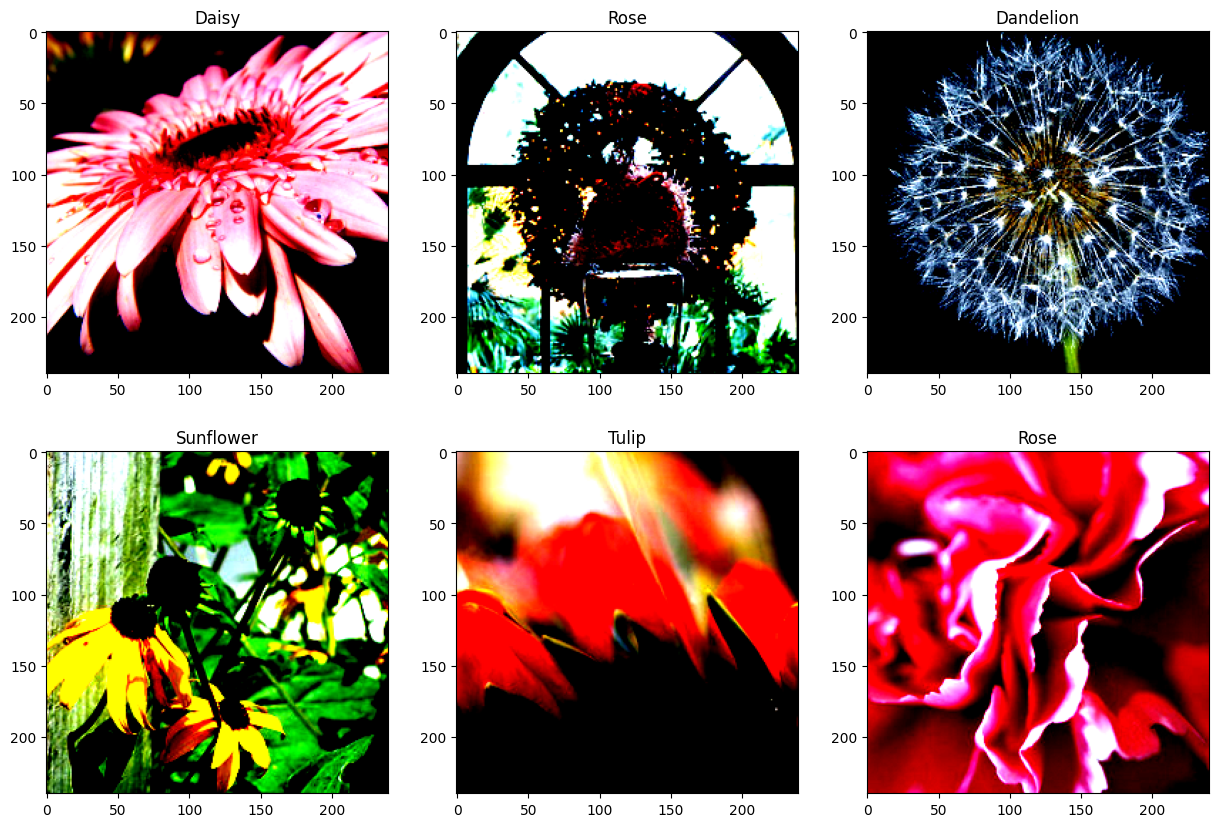

In [ ]:
# Let's quickly visualise a few random images
import random 

label_map = {idx:label for idx, label in enumerate(dataset.classes)}

fig, ax = plt.subplots(2,3, figsize=(15,10))
for i in range(6):
  idx = torch.randint(0, len(train_dataset), size=[1]).item()
  img, label = train_dataset[idx]
  ax[i//3, i%3].imshow(img.permute(1, 2, 0))
  ax[i//3, i%3].set_title(label_map[label].title())


## Step 2: Make Adjustments to Pre-trained model

In [ ]:
# Let's visualise the efficeint net that we will be using and understand what 
# layers we will have to re-adjust

torchinfo.summary(model = model,
                  input_size=(32,3,224,224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Currently there are 7, 794, 184 trainable parameters but we do not intend to re-train *all* paramaters. Instead we will look to re-train the final classification block.

In [ ]:
# Let's freeze the feature layers
for param in model.parameters():
  param.requires_grad = False

# Adjust the output shape to accomodate for 5 classes
model.classifier = nn.Sequential(
    nn.Linear(
        in_features=1280,
        out_features=len(dataset.classes)
    )
)

# Let's now look at the model and see if the final output shape is what we expect
torchinfo.summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Perfect! The final linear layer now has an output shape of [32, 5]. This means that for each batch, the model will output 5 probabilities per image. These probabilities will indicate the probability that each image is in a given class. Additionally, note that the number of trainable parameters has *significantly* reduced to 6405 which will be much more manageable for us.

## Step 3: Building the Training and Testing Loop
### The steps in this section are as follows:
1. Define the loss function and the optimizer
2. Define the following functions:
  - `train_step()` - trains the model
  - `test_step()` - tests the model
  - `train()` - runs the first two functions for a number of epochs
3. Train and test the model

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
# Define the three functions above
from tqdm.auto import tqdm

# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 1. Training step function

def training_step(model, 
                  dataloader, 
                  loss_fn, 
                  optimizer,
                  device):

  # Put the model into training model
  model.train()

  # Loss and accuracy variables
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    # Move X and y to the device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_logits = model(X)

    # Calculate the loss and the accuracy
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # predict the class
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    acc = (y_pred == y).sum().item()/len(y_pred)
    train_acc += acc

    if batch % 10 == 0:
      print(f"Batch {batch}: Train Accuracy: {acc} | Train Loss: {loss}")

  # Average the loss and accuracy over all batches
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def test_step(model, 
                  dataloader, 
                  loss_fn, 
                  optimizer,
                  device):
  # Put the model in evaluation mode
  model.eval()

  # Test loss and accuracy variables
  test_loss, test_acc = 0, 0

  # Test the model
  with torch.inference_mode():
    for batch , (X, y) in enumerate(dataloader):
      # Move X and y to the device (gpu)
      X, y = X.to(device), y.to(device)

      # Forward pass to determine the logits
      test_pred_logits = model(X)

      # Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Convert logits to a classification prediction
      test_pred = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      
      # Calculate the accuracy
      acc = (test_pred == y).sum().item()/len(y)
      test_acc += acc
    
    # Average loss and accuracy over all batches
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


def train(model, 
          train_dataloader, 
          test_dataloader, 
          loss_fn, 
          optimizer, 
          epochs,
          device):
  results = {
      'train_loss': [],
      'test_loss': [],
      'train_acc': [],
      'test_acc': []
  }
  for epoch in range(epochs):
    print("-"*50, f"Epoch {epoch+1}", "-"*50)
    train_loss, train_acc = training_step(model,
                                          train_dataloader,
                                          loss_fn,
                                          optimizer,
                                          device)
    test_loss, test_acc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer,
                                    device)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    print(f"Train loss: {train_loss} | Train Accuracy: {train_acc} | Test Loss: "
          f"{test_loss} | Test Accuracy: {test_acc}")
  return results


In [ ]:
epochs = 8
results = train(model, train_loader, test_loader, loss_fn, optimizer, epochs, device)

-------------------------------------------------- Epoch 1 --------------------------------------------------
Batch 0: Train Accuracy: 0.90625 | Train Loss: 0.2050788402557373
Batch 10: Train Accuracy: 0.90625 | Train Loss: 0.3195536434650421
Batch 20: Train Accuracy: 0.75 | Train Loss: 0.44205424189567566
Batch 30: Train Accuracy: 0.9375 | Train Loss: 0.213873952627182
Batch 40: Train Accuracy: 0.84375 | Train Loss: 0.41604891419410706
Batch 50: Train Accuracy: 0.9375 | Train Loss: 0.2844153344631195
Batch 60: Train Accuracy: 0.96875 | Train Loss: 0.168710395693779
Batch 70: Train Accuracy: 0.96875 | Train Loss: 0.15460732579231262
Batch 80: Train Accuracy: 0.96875 | Train Loss: 0.12166061997413635
Batch 90: Train Accuracy: 0.96875 | Train Loss: 0.16205132007598877
Batch 100: Train Accuracy: 0.90625 | Train Loss: 0.3826654553413391
Train loss: 0.27699078364228763 | Train Accuracy: 0.9030371966794382 | Test Loss: 0.2731266457725454 | Test Accuracy: 0.8993055555555556
------------------